<a href="https://colab.research.google.com/github/y-lims/DADS7202_Potato/blob/main/semi_sup_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Lib

In [15]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

# from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

import os
import sys
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
# from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image, display
import matplotlib.cm as cmp
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split

import os
import numpy as np
import tensorflow as tf

import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt



Python 3.10.12 (main, Jul 29 2024, 16:56:48) [GCC 11.4.0]

NumPy 1.26.4

Matplotlib 3.7.1

TensorFlow 2.17.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 0 GPU(s):


#Set up

In [16]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
np_random_seed = 1
tf_random_seed = 1
model_name = 'vgg16'
version = 'v1'
seedno = 1
owner_name = 'l_model'


# Define a flag to check if running on Colab
on_colab = 'google.colab' in str(get_ipython())

# -----------------------------------------------------------------
np.random.seed(np_random_seed)
tf.random.set_seed(tf_random_seed)

In [17]:
if on_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = '/content/drive/My Drive/Final_Potato'
else:
    base_path = 'D:/anaconda3/envs/tfv1/00_deep_prj/Final_Potato'

# Construct the file path
file_path = f'{base_path}/{owner_name}/{model_name}_{version}_{seedno}_{np_random_seed}_{tf_random_seed}_train_incorrect.csv'

# Read the CSV file
incorr_indices_read = pd.read_csv(file_path)
print(incorr_indices_read.head())


# Read Train dataset

Processing class: Healthy


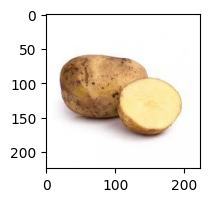

#Label : (90,)
#Un Label : (215,)
Processing class: Blackleg


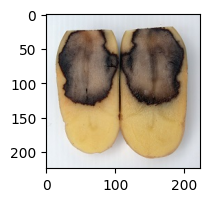

#Label : (20,)
#Un Label : (40,)
Processing class: Black Scurf


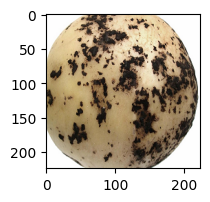

#Label : (20,)
#Un Label : (38,)
Processing class: Pink Rot


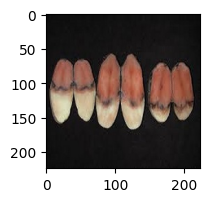

#Label : (20,)
#Un Label : (37,)
Processing class: Common Scab


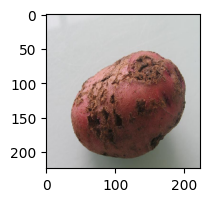

#Label : (20,)
#Un Label : (42,)
Processing class: Dry Rot


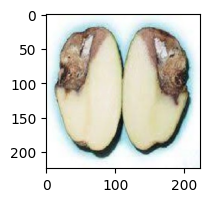

#Label : (20,)
#Un Label : (40,)
Labeled data shape: (190, 224, 224, 3) (190,)
Unlabeled data shape: (412, 224, 224, 3) (412,)


In [30]:
import numpy as np
import os
import tensorflow as tf
from sklearn.utils import shuffle

allowed_extensions = (".JPG", ".jpg", ".jpeg", ".JPEG", ".PNG", ".png")
class_mapping = {'Healthy': 0, 'Blackleg': 1, 'Black Scurf': 2, 'Pink Rot': 3, 'Common Scab': 4, 'Dry Rot': 5}

def process_dataset_with_split(folder_path, class_name, num_labeled=20):
    print(f'Processing class: {class_name}')
    x_labeled, y_labeled, z_labeled = [], [], []
    x_unlabeled, y_unlabeled, z_unlabeled = [], [], []

    # Collect files and shuffle
    file_paths = [os.path.join(folder_path, class_name, filename) for filename in os.listdir(os.path.join(folder_path, class_name))
                  if filename.endswith(allowed_extensions)]
    file_paths = shuffle(file_paths, random_state=42)  # Use random_state for consistency

    # Split data
    labeled_files = file_paths[:num_labeled]
    unlabeled_files = file_paths[num_labeled:]

    # Load images and assign to labeled or unlabeled
    for file_path in labeled_files:
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8)
        x_labeled.append(img_array)
        y_labeled.append(class_mapping[class_name])

    for file_path in unlabeled_files:
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8)
        x_unlabeled.append(img_array)
        y_unlabeled.append(class_mapping[class_name])

    return (np.array(x_labeled), np.array(y_labeled)), (np.array(x_unlabeled), np.array(y_unlabeled))

# Example usage for loading and splitting data
folder_path = '/content/drive/My Drive/Final_Potato/train_data/archive/'
x_labeled, y_labeled, x_unlabeled, y_unlabeled = [], [], [], []

for class_name in class_mapping.keys():
    if class_name == 'Healthy':
        num_labeled = 90
    else:
        num_labeled = 20
    (x_l, y_l), (x_u, y_u) = process_dataset_with_split(folder_path, class_name,  num_labeled)
    plt.figure(figsize = (2,2))
    plt.imshow(x_l[0])
    plt.show()
    print('#Label :', y_l.shape)
    print('#Un Label :', y_u.shape)
    print('====================================================')

    x_labeled.append(x_l)
    y_labeled.append(y_l)
    x_unlabeled.append(x_u)
    y_unlabeled.append(y_u)

# Concatenate arrays from all classes
x_labeled = np.concatenate(x_labeled, axis=0)
y_labeled = np.concatenate(y_labeled, axis=0)
x_unlabeled = np.concatenate(x_unlabeled, axis=0)
y_unlabeled = np.concatenate(y_unlabeled, axis=0)

print('Labeled data shape:', x_labeled.shape, y_labeled.shape)
print('Unlabeled data shape:', x_unlabeled.shape, y_unlabeled.shape)


# Read Test Dataset

==== Healthy ====
Shape of x (Healthy): (307, 224, 224, 3)
Shape of y (Healthy): (307,)
latest index :  306


array([[[220, 221, 216],
        [218, 219, 214],
        [207, 208, 203],
        ...,
        [200, 201, 195],
        [201, 202, 196],
        [201, 202, 196]],

       [[215, 216, 211],
        [211, 212, 207],
        [220, 221, 216],
        ...,
        [198, 199, 193],
        [201, 202, 196],
        [201, 202, 196]],

       [[219, 220, 215],
        [210, 211, 206],
        [216, 217, 212],
        ...,
        [202, 203, 197],
        [201, 202, 196],
        [202, 203, 197]],

       ...,

       [[203, 204, 198],
        [203, 204, 198],
        [203, 204, 198],
        ...,
        [195, 196, 190],
        [196, 197, 191],
        [197, 198, 192]],

       [[202, 203, 197],
        [204, 205, 199],
        [204, 205, 199],
        ...,
        [195, 196, 190],
        [195, 196, 190],
        [195, 196, 190]],

       [[201, 202, 196],
        [204, 205, 199],
        [204, 205, 199],
        ...,
        [195, 196, 190],
        [192, 193, 187],
        [194, 195, 189]]], dtype=uint8)
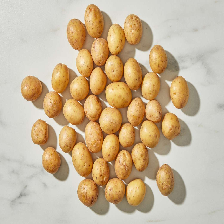

==== Blackleg ====
Shape of x (Blackleg): (60, 224, 224, 3)
Shape of y (Blackleg): (60,)
latest index :  366


array([[[182, 176, 180],
        [183, 177, 181],
        [183, 177, 181],
        ...,
        [165, 170, 166],
        [165, 170, 166],
        [166, 171, 167]],

       [[181, 175, 179],
        [184, 178, 182],
        [184, 178, 182],
        ...,
        [164, 169, 165],
        [164, 169, 165],
        [164, 169, 165]],

       [[180, 174, 178],
        [184, 178, 182],
        [184, 178, 182],
        ...,
        [165, 167, 164],
        [165, 167, 164],
        [165, 167, 164]],

       ...,

       [[194, 195, 213],
        [195, 196, 214],
        [195, 196, 214],
        ...,
        [190, 198, 211],
        [190, 198, 211],
        [194, 202, 215]],

       [[191, 192, 212],
        [192, 193, 213],
        [192, 193, 213],
        ...,
        [187, 195, 208],
        [187, 195, 208],
        [189, 197, 210]],

       [[199, 200, 221],
        [188, 189, 210],
        [188, 189, 210],
        ...,
        [189, 197, 210],
        [189, 197, 210],
        [188, 196, 209]]], dtype=uint8)
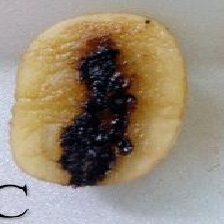


==== Black Scurf ====
Shape of x (Black Scurf): (66, 224, 224, 3)
Shape of y (Black Scurf): (66,)
latest index :  432


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
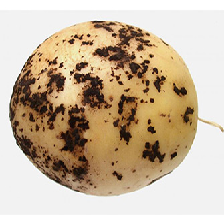


==== Pink Rot ====
Shape of x (Pink Rot): (51, 224, 224, 3)
Shape of y (Pink Rot): (51,)
latest index :  483


array([[[ 8,  8,  8],
        [ 6,  6,  6],
        [14, 14, 14],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[ 9,  9,  9],
        [ 8,  8,  8],
        [ 8,  8,  8],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       [[ 5,  5,  5],
        [ 6,  6,  6],
        [ 4,  4,  4],
        ...,
        [ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1]],

       ...,

       [[ 3,  3,  3],
        [ 4,  4,  4],
        [ 4,  4,  4],
        ...,
        [ 5,  5,  5],
        [ 5,  5,  5],
        [ 5,  5,  5]],

       [[ 8,  8,  8],
        [ 7,  7,  7],
        [ 8,  8,  8],
        ...,
        [ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2]],

       [[66, 66, 66],
        [65, 65, 65],
        [66, 66, 66],
        ...,
        [65, 65, 65],
        [65, 65, 65],
        [65, 65, 65]]], dtype=uint8)
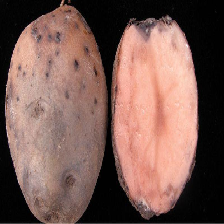


==== Common Scab ====
Shape of x (Common Scab): (60, 224, 224, 3)
Shape of y (Common Scab): (60,)
latest index :  543


array([[[15, 14, 10],
        [16, 15, 11],
        [17, 16, 12],
        ...,
        [15, 14, 10],
        [15, 14, 10],
        [15, 14, 10]],

       [[16, 15, 11],
        [16, 15, 11],
        [16, 15, 11],
        ...,
        [15, 14, 10],
        [15, 14, 10],
        [14, 13,  9]],

       [[17, 16, 12],
        [16, 15, 11],
        [15, 14, 10],
        ...,
        [15, 14, 10],
        [15, 14, 10],
        [16, 15, 11]],

       ...,

       [[20, 16, 13],
        [18, 14, 11],
        [16, 12,  9],
        ...,
        [15, 14, 10],
        [15, 14, 10],
        [15, 14, 10]],

       [[18, 14, 11],
        [18, 14, 11],
        [18, 14, 11],
        ...,
        [13, 12,  8],
        [17, 16, 12],
        [19, 18, 14]],

       [[18, 14, 11],
        [17, 13, 10],
        [19, 15, 12],
        ...,
        [14, 13,  9],
        [14, 13,  9],
        [15, 14, 10]]], dtype=uint8)
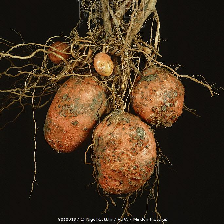


==== Dry Rot ====
Shape of x (Dry Rot): (51, 224, 224, 3)
Shape of y (Dry Rot): (51,)
latest index :  594


array([[[234, 236, 235],
        [234, 236, 235],
        [234, 236, 235],
        ...,
        [242, 244, 243],
        [242, 244, 243],
        [242, 244, 243]],

       [[234, 236, 235],
        [234, 236, 235],
        [234, 236, 235],
        ...,
        [242, 244, 243],
        [242, 244, 243],
        [242, 244, 243]],

       [[234, 236, 235],
        [234, 236, 235],
        [234, 236, 235],
        ...,
        [242, 244, 243],
        [242, 244, 243],
        [242, 244, 243]],

       ...,

       [[228, 230, 229],
        [228, 230, 229],
        [228, 230, 229],
        ...,
        [240, 242, 241],
        [240, 242, 241],
        [240, 242, 241]],

       [[228, 230, 229],
        [228, 230, 229],
        [228, 230, 229],
        ...,
        [240, 242, 241],
        [240, 242, 241],
        [240, 242, 241]],

       [[228, 230, 229],
        [228, 230, 229],
        [228, 230, 229],
        ...,
        [240, 242, 241],
        [240, 242, 241],
        [240, 242, 241]]], dtype=uint8)
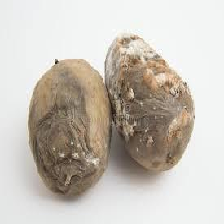

In [33]:
def process_dataset_nosplit(folder_path, class_name):

    print(f'==== {class_name} ====')
    x, y, z = [], [], []
    for filename in os.listdir(os.path.join(folder_path, class_name)):
        if filename.endswith(allowed_extensions):
            file_path = os.path.join(folder_path, class_name, filename)
            img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8)
            x.append(img_array)
            y.append(class_mapping[class_name])
            z.append([class_name, filename])


    x = np.array(x)
    y = np.array(y).reshape(-1,)
    print(f"Shape of x ({class_name}):", x.shape)
    print(f"Shape of y ({class_name}):", y.shape)
    return x, y, z


def process_dataset_with_split(folder_path, class_name, num_labeled=20):
    print(f'Processing class: {class_name}')
    x_labeled, y_labeled, z_labeled = [], [], []
    x_unlabeled, y_unlabeled, z_unlabeled = [], [], []

    # รวบรวมไฟล์และสุ่ม
    file_paths = [os.path.join(folder_path, class_name, filename) for filename in os.listdir(os.path.join(folder_path, class_name))
                  if filename.endswith(allowed_extensions)]
    file_paths = shuffle(file_paths, random_state=42)  # ใช้ random_state เพื่อความสอดคล้อง

    # แบ่งข้อมูล
    labeled_files = file_paths[:num_labeled]
    unlabeled_files = file_paths[num_labeled:]

    # โหลดภาพและแบ่งข้อมูล
    for file_path in labeled_files:
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8)
        x_labeled.append(img_array)
        y_labeled.append(class_mapping[class_name])
        z_labeled.append([class_name, os.path.basename(file_path)])

    for file_path in unlabeled_files:
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img_array = tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8)
        x_unlabeled.append(img_array)
        y_unlabeled.append(class_mapping[class_name])
        z_unlabeled.append([class_name, os.path.basename(file_path)])

    return (np.array(x_labeled), np.array(y_labeled), z_labeled), (np.array(x_unlabeled), np.array(y_unlabeled), z_unlabeled)

# ==========================================================================================

folder_path = f'{base_path}/test_data/'
x, y, z = process_dataset_nosplit(folder_path, 'Healthy')
x_combined, y_combined, z_combined = x, y, z
print('latest index : ', len(x_combined) - 1)
display(x[0])

check_ind = [len(x_combined) - 1]
check_class = ['Healthy']
for i in list(class_mapping.keys())[1:]:
    x, y, z = process_dataset_nosplit(folder_path, i)
    x_combined = np.concatenate((x_combined, x), axis=0)
    y_combined = np.concatenate((y_combined, y), axis=0)
    z_combined = np.concatenate((z_combined, z), axis=0)
    print('latest index : ', len(x_combined) - 1)
    display(x[0])
    print()
    check_ind.append(len(x_combined) - 1)
    check_class.append(i)

x_test, y_test = x_combined, y_combined

# Data Prep  label and unlabel for specific model 🚧🚧🚧🚧🚧🚧🚧🚧

In [98]:

# Label data
from sklearn.utils import shuffle
x_labeled_shuffle, y_labeled_shuffle = shuffle(x_labeled,  y_labeled, random_state=42)
x_labeled_model = tf.keras.applications.vgg16.preprocess_input(x_labeled_shuffle)
y_labeled_model = y_labeled_shuffle

# Unlabel data
x_unlabeled_model = tf.keras.applications.vgg16.preprocess_input(x_unlabeled)
y_unlabeled_model = y_unlabeled

# Test  data
x_test_model = tf.keras.applications.vgg16.preprocess_input(x_test)
y_test_model = y_test


print( x_labeled_model.dtype, x_labeled_model.shape, np.min(x_labeled_model), np.max(x_labeled_model) )
print( y_unlabeled_model.dtype, y_unlabeled_model.shape, np.min(y_unlabeled_model), np.max(y_unlabeled_model) )

float32 (190, 224, 224, 3) -123.68 151.061
int64 (412,) 0 5


# Data Augmented layers

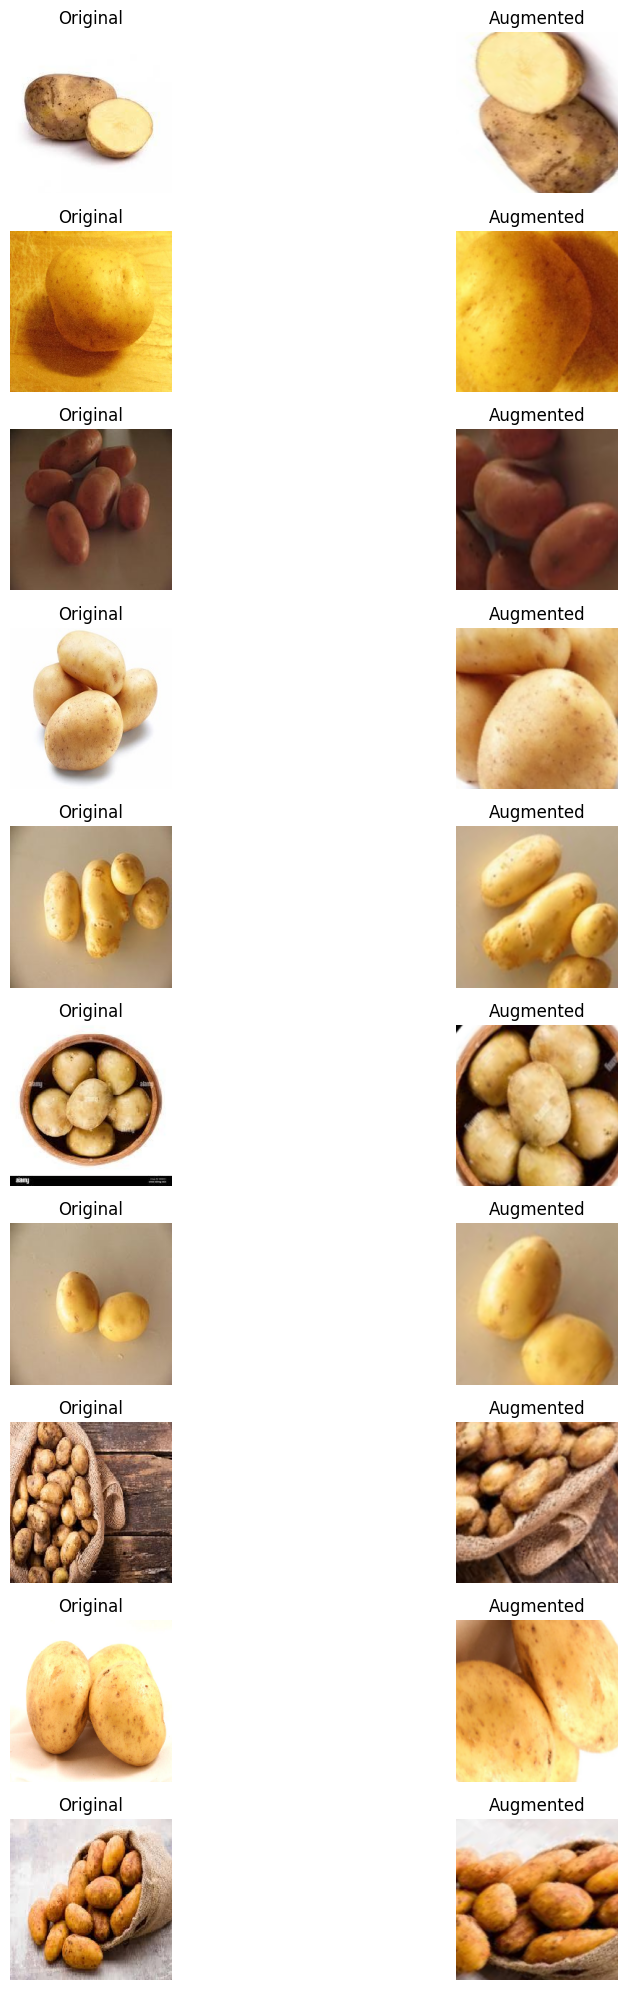

In [38]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Create data augmentation pipeline with additional transformations
data_augmentation = tf.keras.Sequential([
    # layers.Rescaling(1./255),
    # layers.RandomFlip("horizontal"),
    # layers.RandomFlip("vertical"),  # Additional flip for vertical flipping
    layers.RandomRotation(0.4),
    layers.RandomZoom(height_factor=(-0.2, -0.5), width_factor=(-0.2, -0.5)),  # Zoom in only
    # layers.RandomContrast(0.9),  # Adjust contrast randomly
    # layers.RandomCrop(height=180, width=180),  # Randomly crop to 180x180 from original size
    # layers.CenterCrop(height=150, width=150),  # Center crop to 150x150
])

# ===========================================

# Assume you have image data in x_train
# We will select some images from x_train to show examples
num_examples = 10 # Number of images to display
sample_images = x_labeled[:num_examples]

# Apply data augmentation to sample images
augmented_images = data_augmentation(sample_images)

# Display original and augmented images in pairs
plt.figure(figsize=(12, 2 * num_examples))
for i in range(num_examples):
    # Original image
    plt.subplot(num_examples, 2, 2 * i + 1)
    plt.imshow(sample_images[i].astype("uint8"))
    plt.axis("off")
    plt.title("Original")

    # Augmented image
    plt.subplot(num_examples, 2, 2 * i + 2)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title("Augmented")

plt.tight_layout()
plt.show()


# Model [Train on 20% label data]

## Model Selection 🚧🚧🚧🚧🚧🚧🚧🚧

In [42]:
img_w,img_h = 224,224
model_extractor = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))
model_extractor.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Config Layers


In [43]:
model_extractor.trainable = False

# # Access a layer by its name
# b = model_extractor.get_layer('block5_conv1')
# b.trainable = True       # freeze this layer
# print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )

# b = model_extractor.get_layer('block5_conv2')
# b.trainable = True       # freeze this layer
# print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )

b = model_extractor.get_layer('block5_conv3')
b.trainable = True       # freeze this layer
print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )

Layer <Conv2D name=block5_conv3, built=True>: name = block5_conv3 , trainable = True


## Modify Layers

In [46]:
# Create the main model
inputs = tf.keras.Input(shape=(img_w, img_h, 3))
x = data_augmentation(inputs)
x = model_extractor(x, training=False)  # Use the extractor with the augmented data


# FC layer
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(6, activation="softmax")(x)  # output layer for 3 classes

model = tf.keras.models.Model(inputs=inputs, outputs=new_outputs)

# Print the model summary
# model.summary()
model.summary(expand_nested=True)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_1               │ (10, 224, 224, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom_1 (RandomZoom)      │ (10, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)         │       2,359,8

 Total params: 27,563,334 (105.15 MB)

 Trainable params: 15,208,454 (58.02 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

## Compile

In [48]:
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) ,
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=['acc']
                     )

history = model.fit(x_labeled_model, y_labeled_model,
                    epochs=1,
                    batch_size=64,
                    verbose=2,
                    validation_split=0.2)


3/3 - 163s - 54s/step - acc: 0.9276 - loss: 0.4325 - val_acc: 0.6316 - val_loss: 11.1414


## Save model

In [52]:
from keras.saving import save_model

model_path = f'{base_path}/{owner_name}/sem_supervised/{model_name}_{version}_{seedno}_{np_random_seed}_{tf_random_seed}.keras'
save_model(model, model_path)

## Load model

In [53]:
from tensorflow.keras.models import load_model
if on_colab:
  drive.mount('/content/drive')

model = load_model(model_path)
model.summary(expand_nested=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_1               │ (10, 224, 224, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom_1 (RandomZoom)      │ (10, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)         │       2,359,8

 Total params: 57,980,244 (221.18 MB)

 Trainable params: 15,208,454 (58.02 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

 Optimizer params: 30,416,910 (116.03 MB)

## Save History

In [56]:

import pickle
history_path = f'{base_path}/{owner_name}/sem_supervised/{model_name}_{version}_{seedno}_{np_random_seed}_{tf_random_seed}_history.pkl'

# บันทึกข้อมูลประวัติการฝึกอบรมลงในไฟล์
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f)

# สำหรับการโหลดข้อมูลประวัติการฝึกอบรมกลับมาใช้งาน
with open(history_path, 'rb') as f:
    loaded_history = pickle.load(f)

# ทดสอบการแสดงข้อมูล
print(loaded_history)

{'acc': [0.9276315569877625], 'loss': [0.43246474862098694], 'val_acc': [0.6315789222717285], 'val_loss': [11.141438484191895]}


Plot

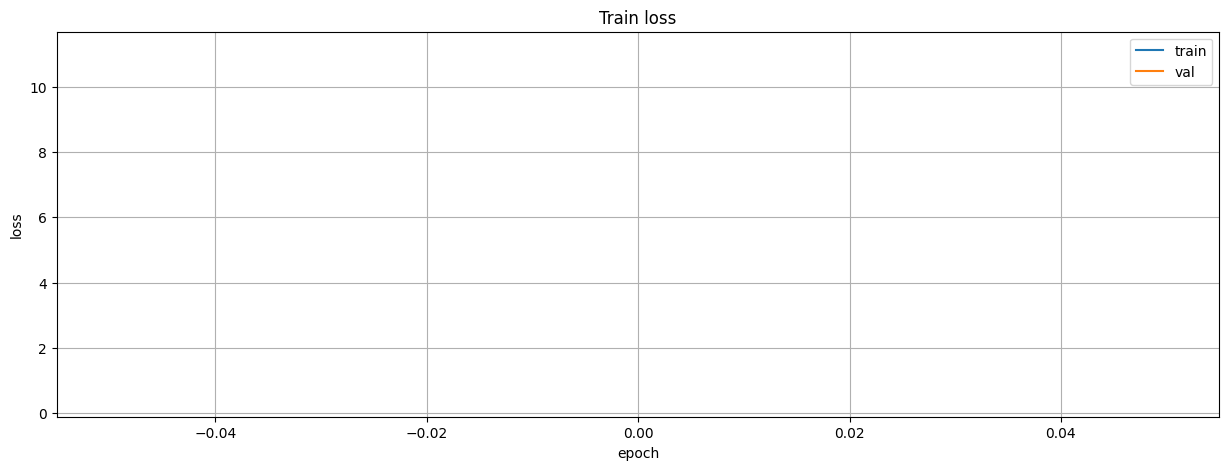

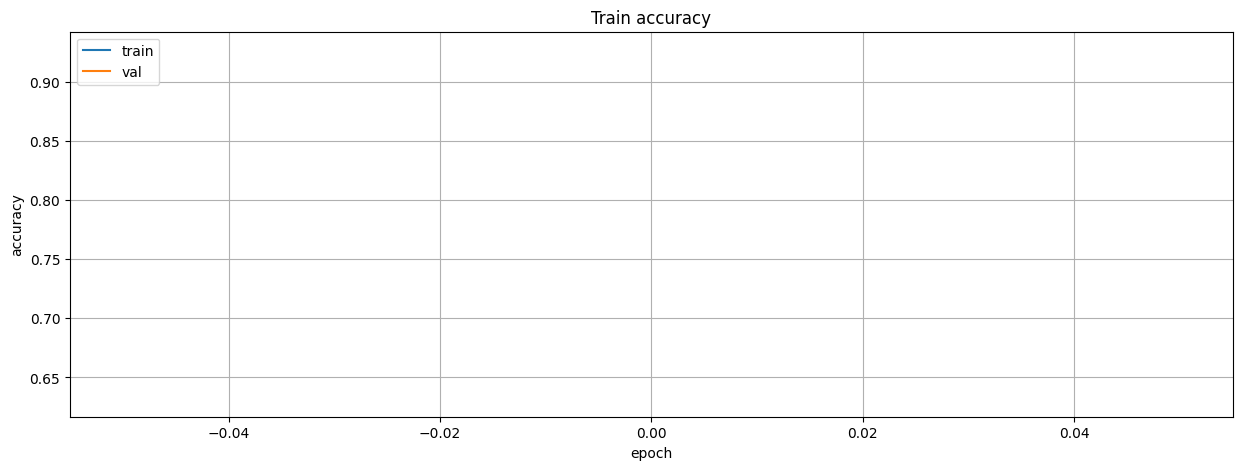

In [57]:
# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

## Evaluation 🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧

### Evaluate on Label set

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 925ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706

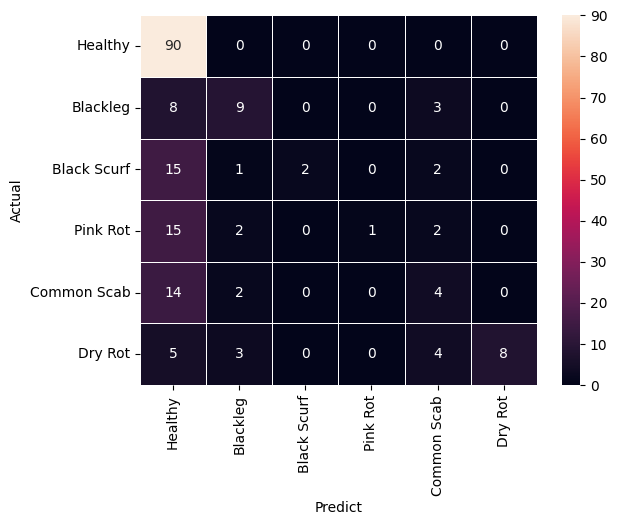

Accuracy: 0.6000
Recall: 0.3667
Precision: 0.7347
F1 Score: 0.3872
Indices of incorrect predictions: [93, 94, 96, 97, 98, 100, 102, 103, 106, 107, 108, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 154, 155, 156, 157, 158, 159, 161, 163, 165, 166, 167, 168, 169, 170, 171, 172, 174, 177, 178, 181, 183, 184, 186, 187, 189]


In [58]:
# x_labeled = np.concatenate(x_labeled, axis=0)
# y_labeled = np.concatenate(y_labeled, axis=0)

# x_unlabeled = np.concatenate(x_unlabeled, axis=0)
# y_unlabeled = np.concatenate(y_unlabeled, axis=0)

label = [k for k, v in class_mapping.items()]

x_train = x_labeled_model
y_train = y_labeled_model


y_pred = []
for i in range(len(x_train)):
    x_input = x_train[i][np.newaxis, ...]
    y_pred.append(np.argmax(model.predict(x_input , verbose=0)))

cm = confusion_matrix(y_train, y_pred)

# Plotting the confusion matrix
ax = sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label, linewidths=.5)
ax.set(xlabel='Predict', ylabel='Actual')
plt.show()

# Calculating and printing accuracy, recall, precision, and f1-score
accuracy = accuracy_score(y_train, y_pred)
recall = recall_score(y_train, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
precision = precision_score(y_train, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
f1 = f1_score(y_train, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')

# Extracting indices of wrong predictions
train_incorrect_indices = [i for i, (pred, actual) in enumerate(zip(y_pred, y_train)) if pred != actual]
print("Indices of incorrect predictions:", train_incorrect_indices)
print('===========================================')
results = model.evaluate(x_labeled, y_labeled, batch_size=128)
print( f"{model.metrics_names}: {results}" )

### Evaluate on UnLabel set

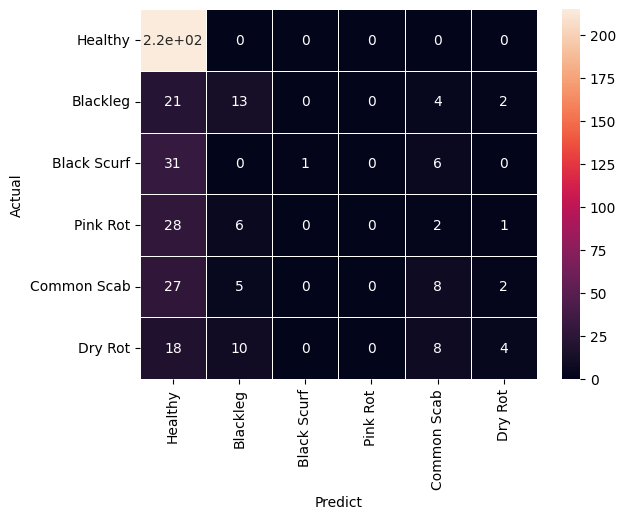

Accuracy: 0.5850
Recall: 0.2736
Precision: 0.4575
F1 Score: 0.2615
Indices of incorrect predictions: [215, 217, 218, 220, 222, 224, 225, 226, 227, 228, 229, 230, 232, 233, 235, 236, 237, 238, 239, 241, 243, 245, 246, 248, 252, 253, 254, 255, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 331, 332, 333, 334, 335, 337, 338, 339, 340, 341, 342, 343, 344, 345, 347, 348, 350, 351, 352, 354, 357, 358, 359, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 401, 402, 403, 405, 406, 407, 408, 409, 411]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
x_test = x_unlabeled_model
y_test = y_unlabeled_model

y_pred = []
for i in range(len(x_test)):
    x_input = x_test[i][np.newaxis, ...]
    y_pred.append(np.argmax(model.predict(x_input , verbose=0)))

cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
ax = sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label, linewidths=.5)
ax.set(xlabel='Predict', ylabel='Actual')
plt.show()

# Calculating and printing accuracy, recall, precision, and f1-score
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
precision = precision_score(y_test, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
f1 = f1_score(y_test, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')

# Extracting indices of wrong predictions
test_incorrect_indices = [i for i, (pred, actual) in enumerate(zip(y_pred, y_test)) if pred != actual]
print("Indices of incorrect predictions:", test_incorrect_indices)
print('===========================================')
results = model.evaluate(x_unlabeled , y_unlabeled , batch_size=128)
print( f"{model.metrics_names}: {results}" )

### New train data

In [100]:
x_train2 = np.concatenate((x_labeled_shuffle ,x_unlabeled) , axis = 0)
y_train2 = np.concatenate( (y_labeled_shuffle ,y_label_for_unlabel) , axis = 0)

print("x_train2 shape :",x_train2.shape)
print("y_train2 shape :",y_train2.shape)

x_train2_shuffle, y_train2_shuffle = shuffle(x_train2,  y_train2, random_state=42)

x_train2_model = tf.keras.applications.vgg16.preprocess_input(x_train2_shuffle)
y_train2_model = y_train2_shuffle

print("x_train2 shape :",x_train2.shape)
print("y_train2 shape :",y_train2.shape)


x_train2 shape : (602, 224, 224, 3)
y_train2 shape : (602,)
x_train2 shape : (602, 224, 224, 3)
y_train2 shape : (602,)


# Mode [On test data]

## Model Selection 🚧🚧🚧🚧🚧🚧🚧🚧

In [85]:
img_w,img_h = 224,224
model_extractor2 = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_w, img_h, 3))
model_extractor2.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Config Layers


In [86]:
model_extractor.trainable = False

# # Access a layer by its name
# b = model_extractor2.get_layer('block5_conv1')
# b.trainable = True       # freeze this layer
# print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )

# b = model_extractor2.get_layer('block5_conv2')
# b.trainable = True       # freeze this layer
# print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )

b = model_extractor2.get_layer('block5_conv3')
b.trainable = True       # freeze this layer
print( f"Layer {b}: name = {b.name} , trainable = {b.trainable}" )

Layer <Conv2D name=block5_conv3, built=True>: name = block5_conv3 , trainable = True


## Modify Layers

In [89]:
# Create the main model
inputs = tf.keras.Input(shape=(img_w, img_h, 3))
x = data_augmentation(inputs)
x = model_extractor2(x, training=False)  # Use the extractor with the augmented data

# FC layer
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(6, activation="softmax")(x)  # output layer for 3 classes

model2 = tf.keras.models.Model(inputs=inputs, outputs=new_outputs)

# Print the model summary
# model.summary()
model2.summary(expand_nested=True)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_1               │ (10, 224, 224, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom_1 (RandomZoom)      │ (10, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)         │       2,359,8

 Total params: 27,563,334 (105.15 MB)

 Trainable params: 27,563,334 (105.15 MB)

 Non-trainable params: 0 (0.00 B)

## Compile

In [101]:
model2.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) ,
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=['acc']
                     )

history2 = model2.fit(x_train2_model, y_train2_model,
                    epochs=1,
                    batch_size=64,
                    verbose=2,
                    validation_split=0.2)


KeyboardInterrupt: 

## Save model

In [ ]:
from keras.saving import save_model

model_path = f'{base_path}/{owner_name}/sem_supervised2/{model_name}_{version}_{seedno}_{np_random_seed}_{tf_random_seed}.keras'
save_model(model2, model_path)

## Load model

In [ ]:
from tensorflow.keras.models import load_model
if on_colab:
  drive.mount('/content/drive')

model2 = load_model(model_path)
model2.summary(expand_nested=True)

## Save History

In [ ]:

import pickle
history_path = f'{base_path}/{owner_name}/sem_supervised/{model_name}_{version}_{seedno}_{np_random_seed}_{tf_random_seed}_history.pkl'

# บันทึกข้อมูลประวัติการฝึกอบรมลงในไฟล์
with open(history_path, 'wb') as f:
    pickle.dump(history2.history, f)

# สำหรับการโหลดข้อมูลประวัติการฝึกอบรมกลับมาใช้งาน
with open(history_path, 'rb') as f:
    loaded_history = pickle.load(f)

# ทดสอบการแสดงข้อมูล
print(loaded_history)

## Plot

In [ ]:
# Summarize history for loss
plt.figure(figsize=(15,5))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.grid()
plt.show()

# Summarize history for accuracy
plt.figure(figsize=(15,5))
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

## Evaluation 🚧🚧🚧🚧🚧🚧🚧🚧🚧🚧

### Evaluate on Label set

In [ ]:
label = [k for k, v in class_mapping.items()]

x_train = x_train2_model
y_train = y_train2_model


y_pred = []
for i in range(len(x_train)):
    x_input = x_train[i][np.newaxis, ...]
    y_pred.append(np.argmax(model.predict(x_input , verbose=0)))

cm = confusion_matrix(y_train, y_pred)

# Plotting the confusion matrix
ax = sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label, linewidths=.5)
ax.set(xlabel='Predict', ylabel='Actual')
plt.show()

# Calculating and printing accuracy, recall, precision, and f1-score
accuracy = accuracy_score(y_train, y_pred)
recall = recall_score(y_train, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
precision = precision_score(y_train, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
f1 = f1_score(y_train, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')

# Extracting indices of wrong predictions
train_incorrect_indices = [i for i, (pred, actual) in enumerate(zip(y_pred, y_train)) if pred != actual]
print("Indices of incorrect predictions:", train_incorrect_indices)
print('===========================================')
results = model.evaluate(x_labeled, y_labeled, batch_size=128)
print( f"{model.metrics_names}: {results}" )

### Evaluate on UnLabel set

In [ ]:
x_test = x_test_model
y_test = y_test_model

y_pred = []
for i in range(len(x_test)):
    x_input = x_test[i][np.newaxis, ...]
    y_pred.append(np.argmax(model.predict(x_input , verbose=0)))

cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
ax = sns.heatmap(cm, annot=True, xticklabels=label, yticklabels=label, linewidths=.5)
ax.set(xlabel='Predict', ylabel='Actual')
plt.show()

# Calculating and printing accuracy, recall, precision, and f1-score
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
precision = precision_score(y_test, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed
f1 = f1_score(y_test, y_pred, average='macro')  # Change 'macro' to 'micro' or 'weighted' as needed

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')

# Extracting indices of wrong predictions
test_incorrect_indices = [i for i, (pred, actual) in enumerate(zip(y_pred, y_test)) if pred != actual]
print("Indices of incorrect predictions:", test_incorrect_indices)
print('===========================================')
results = model.evaluate(x_unlabeled , y_unlabeled , batch_size=128)
print( f"{model.metrics_names}: {results}" )